In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation.mice as smi
import copy

In [2]:
file_path = 'pre_imputed_CA_data.csv'
df = pd.read_csv(file_path, #index_col='time',
                    dtype={'BANC':np.float64,
                          'CISO':np.float64,
                          'LDWP':np.float64,
                          'TIDC':np.float64},
                    parse_dates=True, na_values=['NA',])
df.head(10)

,date_time,BANC,CISO,LDWP,TIDC
0,2015-07-01T05:00:00Z,NaN,NaN,NaN,NaN
1,2015-07-01T06:00:00Z,NaN,NaN,NaN,NaN
2,2015-07-01T07:00:00Z,NaN,NaN,NaN,NaN
3,2015-07-01T08:00:00Z,NaN,NaN,NaN,NaN
4,2015-07-01T09:00:00Z,2275.0,28989.0,3045.0,380.0
5,2015-07-01T10:00:00Z,2104.0,27416.0,2892.0,357.0
6,2015-07-01T11:00:00Z,1988.0,26388.0,2787.0,342.0
7,2015-07-01T12:00:00Z,1958.0,25661.0,2790.0,NaN
8,2015-07-01T13:00:00Z,2006.0,25845.0,2899.0,347.0
9,2015-07-01T14:00:00Z,2076.0,26555.0,3097.0,356.0


In [3]:
df.describe().round(2)

,BANC,CISO,LDWP,TIDC
count,33909.00,34530.00,34175.00,30772.00
mean,1998.16,25947.59,3244.03,298.94
std,512.90,5066.33,752.67,77.42
min,1260.00,14663.00,2019.00,184.00
25%,1675.00,22253.00,2699.00,248.00
50%,1885.00,25154.00,3127.00,279.00
75%,2111.00,28070.75,3532.00,320.00
max,4763.00,49899.00,7095.00,653.00


In [4]:
df.isna().sum(axis=0)

date_time       0
BANC         1004
CISO          383
LDWP          738
TIDC         4141
dtype: int64

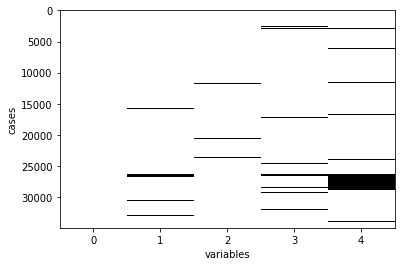

In [5]:
plt.imshow(~df.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  # This is added back by InteractiveShellApp.init_path()


date_time       0
BANC         1004
CISO          383
LDWP          738
TIDC         4141
dtype: int64


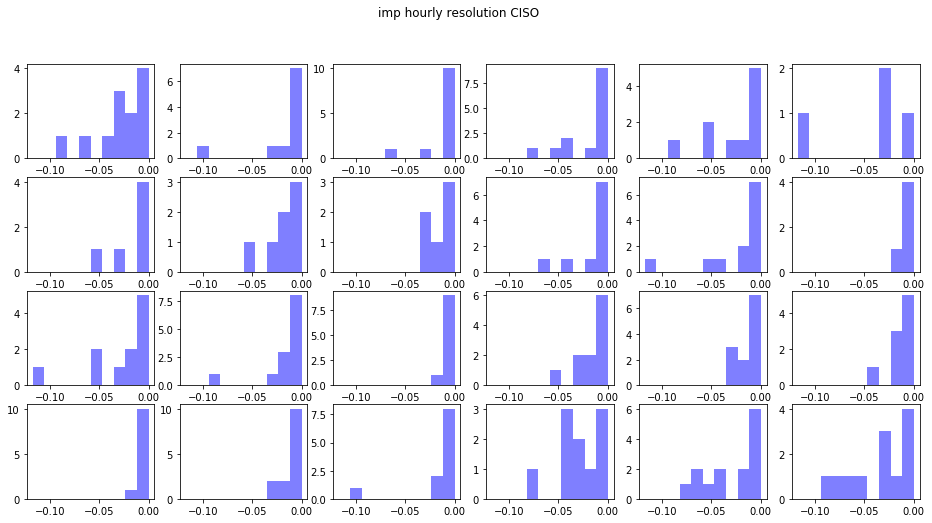

In [6]:
## Open a saved csv and check contents

n1 = pd.read_csv('data00.csv')
n2 = pd.read_csv('data01.csv')
#print(n.head())
#print(n.isna().sum(axis=0))
#n.describe().round(2)


def return_imputed_indices(raw, name):
    index = pd.isnull(df[name]).nonzero()[0]
    return index

def return_imputed_values(imp, indices, name):
    vals = imp.loc[indices, name]
    return vals

def comparison_demand_plot(original, imp, imp_names, title, save):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand')
    plt.title(title)
    ax.plot(original['CISO'], '-', label='CISO Raw')
    for v, name in zip(imp, imp_names):
        ax.plot(v, 'o', label=name)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save)

# Create many demand plots so we can actually see the values
def scrolling_demand(width, original, imp, imp_names, title, save):
    start = 0
    end = width
    i = 0
    tot_l = len(original.index)
    while True:
        s = save.replace('.png', '_{}cnt'.format(i))
        t = title+': cnt {}'.format(i)
        o = original.loc[start:end]
        imps = []
        empty = True
        for im in imp:
            imps.append(im.loc[start:end])
            if len(imps[-1].index) > 0:
                empty = False
        if not empty:
            comparison_demand_plot(o, imps, imp_names, t, s)
        if end == tot_l:
            break
        i += 1
        start += width
        end += width
        if end >= tot_l:
            end = tot_l

def comparison_scatter_plot(v1, v2, t1, t2, title, save):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlabel(t1)
    ax.set_ylabel(t2)
    ax.set_xlim(0, np.max(v1))
    ax.set_ylim(0, np.max(v2))
    plt.title(title)
    ax.plot(v1, v2, '.', label=title)
    #plt.legend()
    plt.savefig(save)

def resolution_per_hour(df_true, df_imp, title, save, n_bins=10):

    if df_true.index.all() != df_imp.index.all():
        print("Indices do not align, exiting resolution_per_hour")
        return 0

    res_grid = []
    for i in range(24):
        res_grid.append([])
    
    for index, value in df_true.items(): 
        mod = index%24
        res_grid[mod].append( (df_imp.at[index]-value) / value)
    
    # Establish common x min and x max for all 24 plots
    min_x, max_x = 0, 0
    for i, lst in enumerate(res_grid):
        #print(i, lst)
        if np.min(lst) < min_x:
            min_x = np.min(lst)
        if np.max(lst) < max_x:
            max_x = np.max(lst)
    
    plt.cla()
    for i in range(1, 25):
        plt.subplot(4, 6, i)
        #plt.text(0.5, 0.9, 'hour {}'.format(i),
        #    fontsize=12, ha='center')
        n, bins, patches = plt.hist(res_grid[i-1], n_bins, 
                    range=[min_x, max_x], facecolor='b', alpha=0.5, density=False)
    plt.gcf().set_figheight(8)
    plt.gcf().set_figwidth(16)
    plt.gcf().suptitle(title)
    plt.savefig(save)
    

indices = return_imputed_indices(df, 'CISO')
print(df.isna().sum(axis=0))
v1 = return_imputed_values(n1, indices, 'CISO')
v2 = return_imputed_values(n2, indices, 'CISO')

r = 'CISO'
n1 = 'v1'
n2 = 'v2'
width = 500
#comparison_demand_plot(df, [v1, v2], [n1, n2], 
#        'Imputation of {}'.format(r), 'imp_dem_{}_comp.png'.format(r))
#scrolling_demand(width, df, [v1, v2], [n1, n2], 
#        'Imputation of {}'.format(r), '/Users/truggles/tmp_plots/imp_dem_{}_comp.png'.format(r))
comparison_scatter_plot(v1.values, v2.values, n1, n2, 
        'Comparing {} vs. {}'.format(n1, n2), 'imp_scatter_{}_comp.png'.format(r))
resolution_per_hour(v1, v2, 'imp hourly resolution {}'.format(r), 
        'imp_hourly_resolution_{}.png'.format(r))


for r in regions:
    print(r)
    plt.clf()
    fig, ax = plt.subplots(figsize=(40,5))
    ax.plot(n[r], 'b.', label='imp')
    ax.plot(df[r], 'r.', label='raw')
    plt.legend()
    plt.savefig('demand_{}.eps'.format(r))

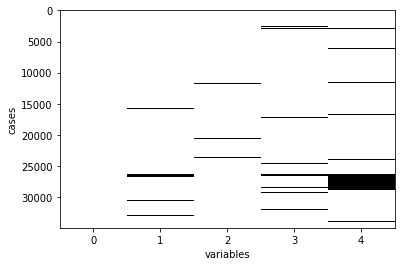

Too many loops for col TIDC and requested length 2593, max good data length 615
find_and_remove_difficult_location
 - Looking for col TIDC for length 2593
 - Best idx 16487 for nan count of 78
 - Difficult NAN insertion resulting in 2638 total np.nans


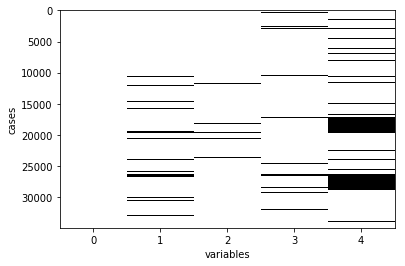

In [7]:
def scan_for_missing_structure(df):
    rec = {}
    for col in df.columns:
        if 'Lag1' in col or 'date_time' in col: continue
        rec[col] = [0, []] # missing tally, and record
    for index, row in df.iterrows():
        for col, info in rec.items():
            if np.isnan(row[col]): # incriment missing tally
                info[0] += 1
            elif not np.isnan(row[col]) and info[0] > 0:
                info[1].append(info[0])
                info[0] = 0
    #for k, v in rec.items():
    #    print(k, v)
    return rec

# Not used
def group_results(groupings, results):
    cats = {}
    for g in groupings:
        cats[g] = 0
    res = {}
    for col, info in results.items():
        res[col] = copy.deepcopy(cats)
        for v in info[1]:
            if v == 1: res[col]['1'] += 1
            elif v <= 5: res[col]['2-5'] += 1
            elif v <= 23: res[col]['5-23'] += 1
            elif v <= 168: res[col]['24-168'] += 1
            elif v <= 1000: res[col]['169-1000'] += 1
            elif v <= 2000: res[col]['1001-2000'] += 1
            elif v <= 3000: res[col]['2001-3000'] += 1
            else: res[col]['3001+'] += 1
    for k, v in res.items():
        print(k, v)
    return res


def remove_locations(df, requested_gaps):
    # Begin with the longest requested gaps and work you way
    # to smaller requested gaps
    for col, info in requested_gaps.items():
        info[1].sort()
        info[1].reverse()
        #print(col, info[1])
        for length in info[1]:
            # Try in requested column first the simple way, if that doesn't
            # work, try the "difficult" way where some existing
            # np.nans will be included in naned data
            if find_and_remove_location(df, col, length):
                find_and_remove_difficult_location(df, col, length)



# Loop over vals in the dataframe and find a continous region which
# has a reasonably "good" data buffer around the requested length of data to remove.
# Change the valse to np.nan
def find_and_remove_location(df, col, length, verbose=False):
    # Start at a random index position to not bias the removals
    # all towards the front
    max_good_data = 0
    loc = int(np.random.uniform(0, len(df.index)))
    if loc == len(df.index):
        loc -= 1
    start_of_good_data = loc
    length_of_good_data = 0
    n_loops = 0
    # How much good data on each side of the new gap?
    if length <= 100:
        tgt_length = 5 * length 
        buffer = 2 * length # 2x on each side
    elif length <= 1000:
        tgt_length = 3 * length 
        buffer = 1 * length # 1x on each side
    else:
        tgt_length = int(1.5 * length) 
        buffer = int(0.25 * length) # 0.25x on each side
    while True:
        if np.isnan(df.at[loc, col]):
            start_of_good_data = loc + 1 # This is the following value
            # and will continuously incriment if isnan()
            length_of_good_data = 0
        else: # good data
            length_of_good_data += 1
            if length_of_good_data > max_good_data:
                max_good_data = length_of_good_data

        # Remember pandas DataFrame has different slice notation that normal python
        # where the terminal value is included in the slice
        if length_of_good_data == tgt_length - 1:
            if verbose:
                print("Found a great spot for removal, col {:}, l={:d}, tgt_l={:d}, buffer={:d}, [{:d}:{:d}]".format(
                        col, length, tgt_length, buffer, start_of_good_data, start_of_good_data+length_of_good_data))
            strt = start_of_good_data + buffer # Begin nan after good data buffer 
            end = start_of_good_data + buffer + length - 1
            if verbose:
                print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            df.loc[strt:end, col] = np.nan
            if verbose:
                print(df.loc[start_of_good_data:start_of_good_data+length_of_good_data, col])
            return 0
        loc += 1
        
        # Wrap to start of df
        if loc >= len(df.index):
            loc = 0
            n_loops += 1
            if n_loops > 1:
                print("Too many loops for col {} and requested length {}, max good data length {}".format(
                    col, length, max_good_data))
                return 1

            
def find_and_remove_difficult_location(df, col, length, verbose=False):
    # Scan data and look for highest purity "good" data region
    # to apply np.nan
    rec = []
    print("find_and_remove_difficult_location")
    print(" - Looking for col {} for length {}".format(col, length))
    for i in range(0, int(len(df.index) - 1.5 * length)):
        rec.append((i, df.loc[i:int(i+1.5*length), col].isna().sum()))
    nan_min = 9999
    best_idx = -1
    for val in rec:
        if val[1] < nan_min:
            nan_min = val[1]
            best_idx = val[0]
    print(" - Best idx {} for nan count of {}".format(best_idx, nan_min))
    df.loc[int(best_idx+0.25*length):int(best_idx+1.25*length), col] = np.nan
    print(" - Difficult NAN insertion resulting in {} total np.nans".format(
        df.loc[best_idx:int(best_idx+1.5*length), col].isna().sum()))
            

np.random.seed(1)
results = scan_for_missing_structure(df)
groupings = ['1', '2-5', '5-23',  '24-168', '169-1000', '1001-2000',
            '2001-3000', '3001+']
#results2 = group_results(groupings, results)
df2 = copy.deepcopy(df)
results2 = copy.deepcopy(results)
plt.imshow(~df2.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()
remove_locations(df2, results2)
plt.imshow(~df2.isna(), aspect='auto')
plt.xlabel("variables")
plt.ylabel("cases")
plt.gray()
plt.show()
#print(results)

In [8]:
df2.to_csv('ca_for_overimpute3.csv', index=False)